#### Example: Utilizing a gradient-based optimizer for circuit sizing

In [ ]:
import torch
from torch.nn import functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import serafin as sf

#### Load input data

In [2]:
df = pd.read_csv('/home/moldenhauert/Documents/repo/PREDATOR/data/geometrical/V10/sym_amplifier_xt018_filtered_data_V10.csv')

In [3]:
geometricalDesignSpace  = ['Ldp1', 'Lcm1', 'Lcm2', 'Lcm4', 'Wdp1', 'Wcm1', 'Wcm2', 'Wcm4', 'Mcm12', 'Mcm22']

outputSpace             = ['a_0', 'ugbw', 'pm', 'gm', 'cmrr', 'psrr_p', 'voff_stat', 'sr_r', 'sr_f', 'idd', 'area']



inversionMaskI          = torch.tensor([False, False, False, False, False, False, False, False, False, False])
logMaskI                = torch.tensor([True, True, True, True, True, True, True, True, False, False])

edValues                = torch.tensor(df[geometricalDesignSpace].values, dtype = torch.float32)

edValues[:, torch.logical_or(inversionMaskI, logMaskI)]   = torch.log10(torch.abs(edValues[:, torch.logical_or(inversionMaskI, logMaskI)]))

inMaxs                  = torch.max(edValues, dim = 0).values
inMins                  = torch.min(edValues, dim = 0).values

edValuesScaled          = (edValues - inMins) / (inMaxs - inMins)



candidate = edValuesScaled[666].requires_grad_(True)

In [4]:
inversionMaskO                  = torch.tensor([False, False, False, True, False, False, False, False, True, False, False])

logMaskO                        = torch.tensor([False, True, False, False, False, False, True, True, True, True, True])

outValues                       = torch.tensor(df[outputSpace].values, dtype = torch.float32)

outValuesOrigin                 = outValues.detach().clone()

outValues[:, inversionMaskO]    = torch.neg(outValues[:, inversionMaskO])

outValues[:, logMaskO]          = torch.log10(outValues[:, logMaskO])

outMaxs                         = torch.max(outValues, dim = 0).values
outMins                         = torch.min(outValues, dim = 0).values

outValuesScaled                 = (outValues - outMins) / (outMaxs - outMins)

#### Set a specification

In [5]:
pdk         = '/home/moldenhauert/.circus/pdk/xt018.yml'
ckt         = '/home/moldenhauert/.circus/ckt/sym.yml'
net         = '/home/moldenhauert/.circus/pdk/xt018/sym.scs'

sym         = sf.operational_amplifier(pdk, ckt, net)

size        = sf.initial_sizing(sym)
prf         = sf.evaluate(sym,size)

spec        = torch.tensor(prf[outputSpace].values)

specInv     = torch.where(inversionMaskO, torch.neg(spec), spec)

specLog     = torch.where(logMaskO, torch.log10(specInv), specInv)

specScaled  = (specLog - outMins) / (outMaxs - outMins)

# Corresponding geometrical input

specGeos    = torch.tensor(size[geometricalDesignSpace].values)

specInvGeos = torch.where(inversionMaskI, torch.neg(specGeos), specGeos)

specLogGeos = torch.where(logMaskI, torch.log10(specInvGeos), specInvGeos)

specScaledGeos =  (specLogGeos - inMins) / (inMaxs - inMins)


#### Optimizer setup

In [6]:
optimizer = torch.optim.Adam([candidate], lr=0.003)

#### Load surrogate model

In [7]:
symModel = torch.jit.load('sym_opamp_model_V10_L1_Scaled_Geo_V2.pt')

#### Set up storages for variable tracing

In [8]:
lossList    = []

feats       = [[], [], [], [], [], [], [], [], [], []]
preds       = [[], [], [], [], [], [], [], [], [], [], []]

posDiff     = torch.tensor([True, True, True, True, True, True, False, True, True, False, False]) # Where a positive difference is desired

#### Optimization run

In [9]:
for k in range(10000):
    #print('Epoch: ' + str(k))
    optimizer.zero_grad()
    features = torch.clamp(candidate, min = 0, max = 1)
    pred = torch.reshape(symModel(features), (1,11))
    loss = torch.sum(torch.where(posDiff, F.relu(torch.abs(specScaled) - torch.abs(pred)), F.relu(torch.abs(pred) - torch.abs(specScaled))))

    lossList.append(loss.item())

    # Input Tracking
    for k, f in enumerate(features):
        feats[k].append(f.item())

    # Output Tracking
    for j, p in enumerate(pred[0]):
        preds[j].append(p.item())

    if loss.item() == 0:
        break
    loss.backward()
    
    optimizer.step()




print(candidate)
print(features)

tensor([ 0.3950,  0.6140,  0.4602,  0.4376,  0.6727,  0.7822,  0.4828,  0.4244,
         0.4788, -0.0250], requires_grad=True)
tensor([0.3950, 0.6140, 0.4602, 0.4376, 0.6727, 0.7822, 0.4828, 0.4244, 0.4788,
        0.0000], grad_fn=<ClampBackward1>)


#### Plot loss value

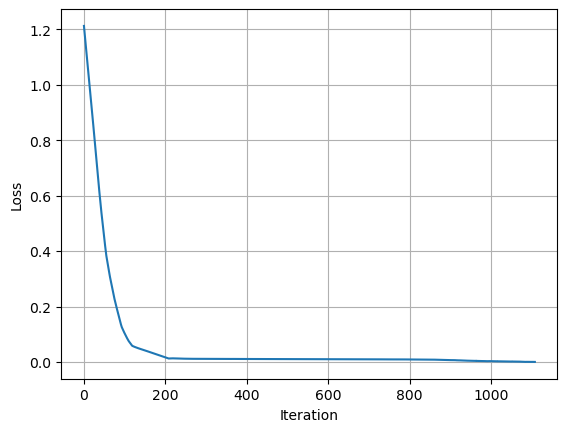

In [10]:
x       = list(range(len(lossList)))
y       = lossList

fig, ax = plt.subplots()

ax.plot(x, y)

ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')

ax.grid()

#### Plot variable trace

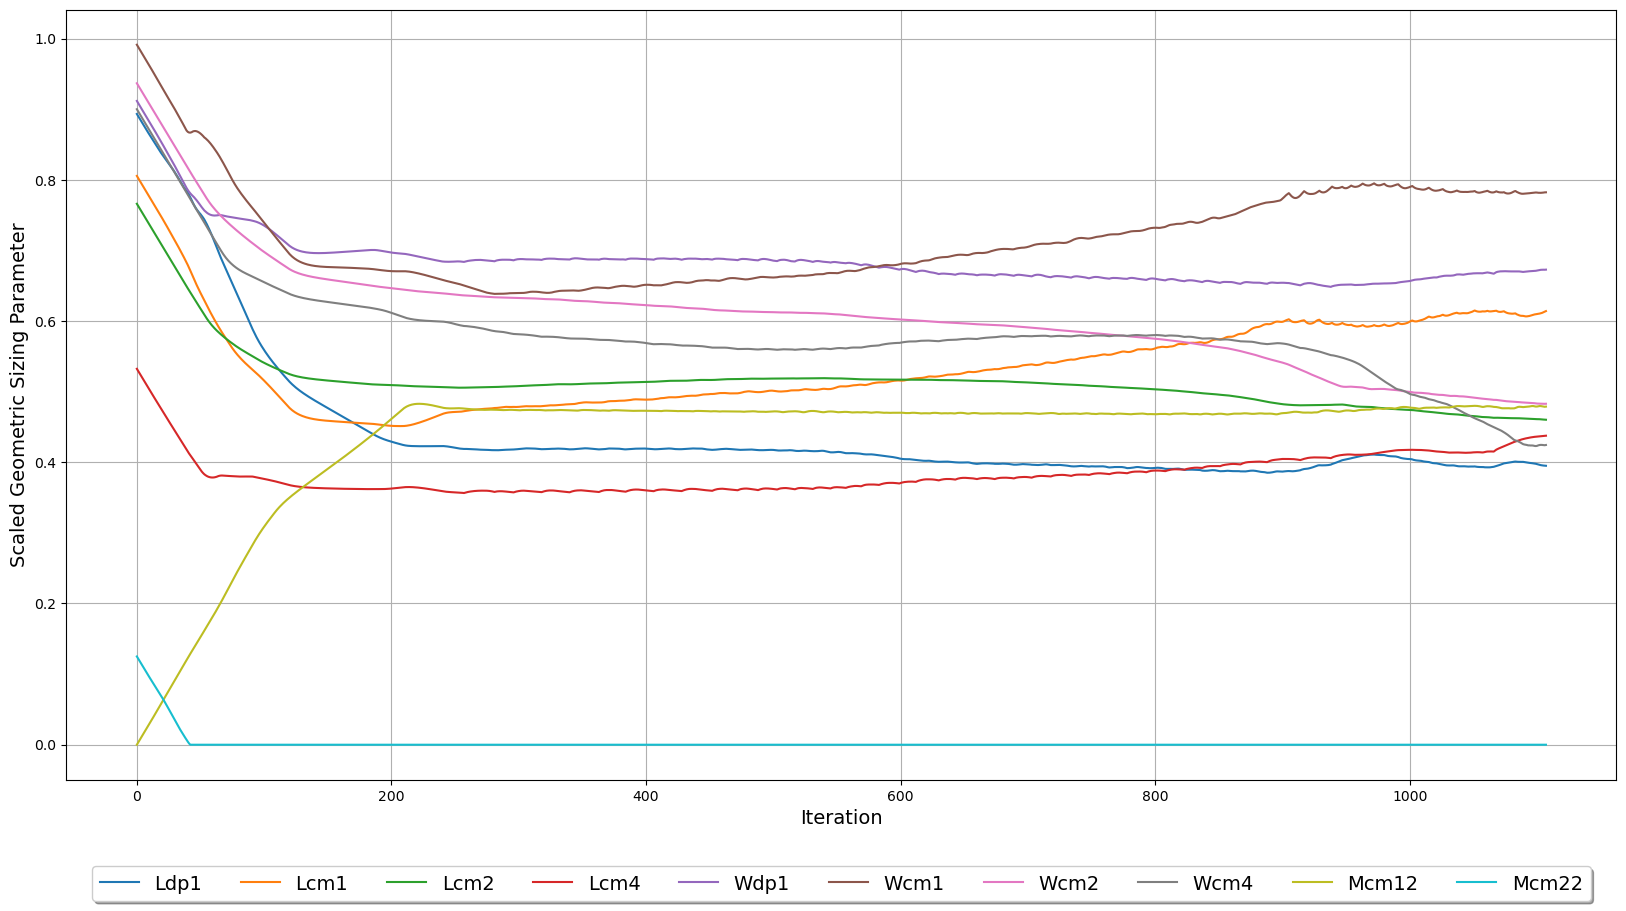

In [11]:
x0      = list(range(len(feats[0])))

fig, ax = plt.subplots(figsize = [20,10])

for lis in feats:
    ax.plot(x0, lis)

ax.legend(geometricalDesignSpace, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol = 10, fontsize = 14)

ax.set_xlabel('Iteration', fontsize = 14)
ax.set_ylabel('Scaled Geometric Sizing Parameter', fontsize = 14)

ax.grid()

#### Specification check

In [12]:
def rescaling(features):
    y = features * (inMaxs - inMins) + inMins

    yLog = torch.where(logMaskI, torch.pow(10, y), y)

    yInv = torch.where(inversionMaskI, torch.neg(yLog), yLog)

    sz = pd.DataFrame(torch.reshape(yInv, (1,10)).detach().numpy(), columns = geometricalDesignSpace)

    sz['Mcm11'] = 1
    sz['Mcm21'] = 1
    sz['Mcm31'] = 1
    sz['Mcm41'] = 2
    sz['Mcm42'] = 2
    sz['Mdp11'] = 2
    sz['Mdp12'] = 2
    sz['Mcm32'] = sz['Mcm22'].values

    sz['Wcm3'] = sz['Wcm2'].values
    sz['Lcm3'] = sz['Lcm2'].values

    sz = sz[['Ldp1', 'Lcm1', 'Lcm2', 'Lcm3', 'Lcm4', 'Wdp1', 'Wcm1', 'Wcm2', 'Wcm3', 'Wcm4', 'Mdp11', 'Mdp12', 'Mcm11', 'Mcm12', 'Mcm21', 'Mcm22', 'Mcm31', 'Mcm32', 'Mcm41', 'Mcm42']]

    return sz

In [13]:
sz = rescaling(features)

In [14]:
prf1  = sf.evaluate(sym,sz)

prf1Vals = prf1[outputSpace].values

#### Performance traces

Text(0, 0.5, 'Scaled Performance Parameter')

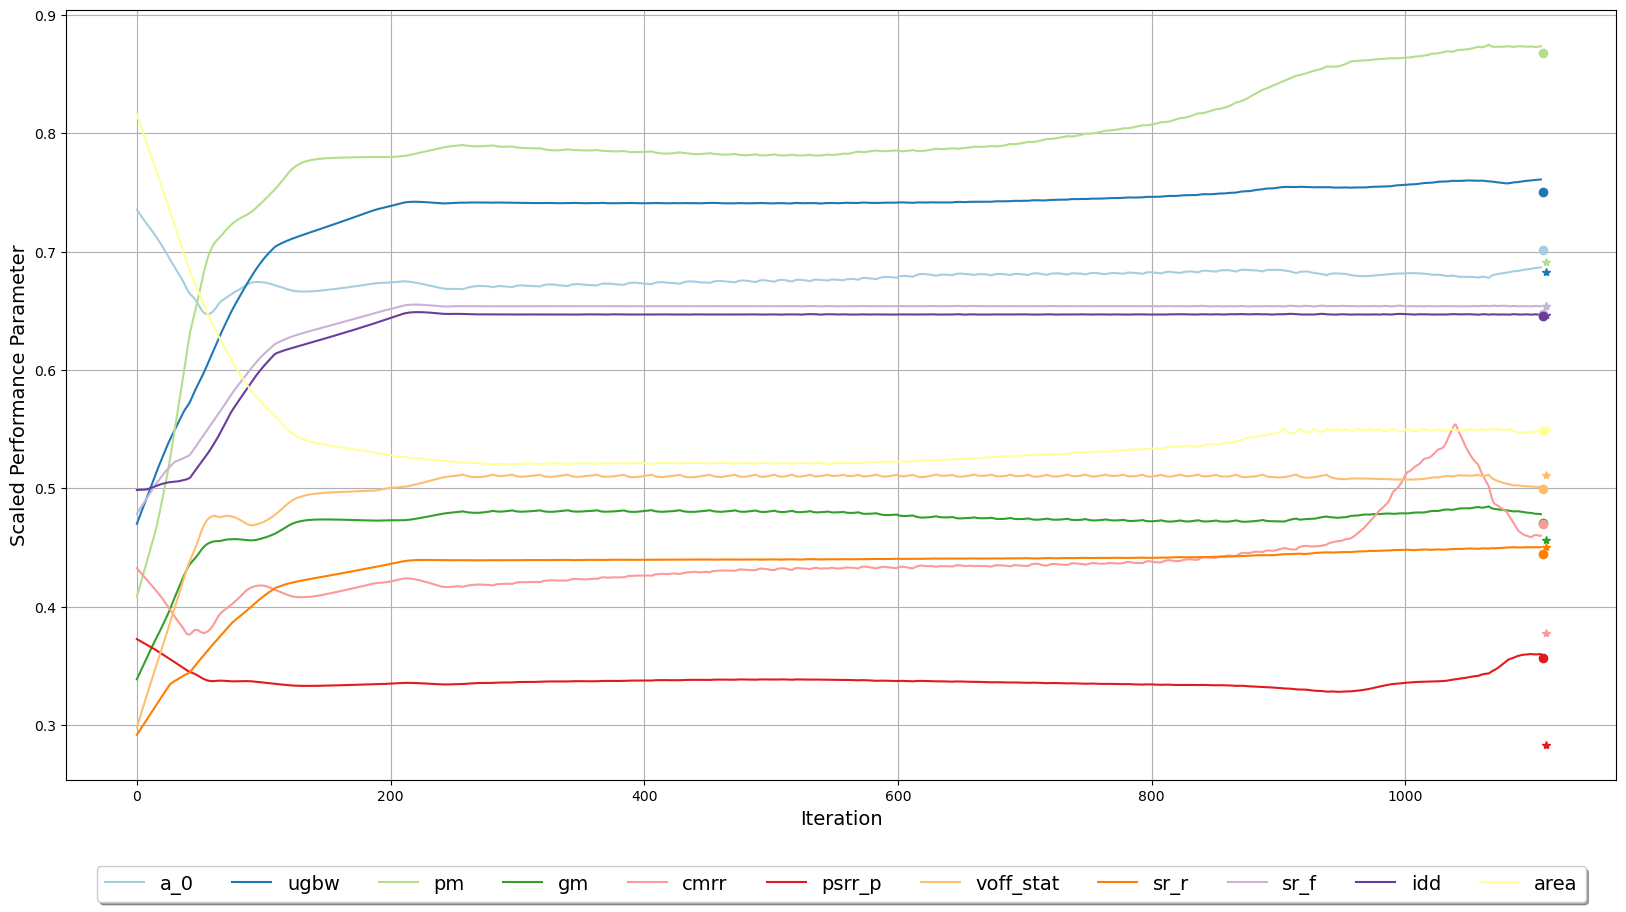

In [15]:
x0          = list(range(len(preds[0])))

NUM_COLORS  = 11

cm          = plt.get_cmap('Paired')
fig         = plt.figure(figsize=[20, 10])
ax          = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for n, lis in enumerate(preds):
    ax.plot(x0, lis)    

for k in range(11):  
    ax.plot(len(preds[0]) +3, specScaled[0][k].item(), '*')
    #ax.axhline(y=specScaled[0][k].item(), linestyle='--')


prf1ValsTensor      = torch.tensor(prf1Vals)

prf1ValsTensorInv   = torch.where(inversionMaskO, torch.neg(prf1ValsTensor),prf1ValsTensor)

prf1ValsTensorLog   = torch.where(logMaskO, torch.log10(prf1ValsTensorInv),prf1ValsTensorInv)

prf1ValsTensorScaled = (prf1ValsTensorLog - outMins) / (outMaxs - outMins)

for z in range(11):  
    ax.plot(len(preds[0])+1, prf1ValsTensorScaled[0][z].item(), 'o')

ax.legend(outputSpace, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=11, fontsize = 14)

ax.grid()

ax.set_xlabel('Iteration', fontsize = 14)
ax.set_ylabel('Scaled Performance Parameter', fontsize = 14)